# A few basic Numpy / array tricks

To use numpy arrays efficiently, you must understand two things in particular that can be a bit tricky. They are "advanced indexing" and "broadcasting.

The official documentation can be found here:
* [Broadcasting](https://docs.scipy.org/doc/numpy/reference/ufuncs.html#ufuncs-broadcasting)
* [Indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

You may find that the documentation is very specific on all the little details, but not so great at explaining how you might use it in practice (eg examples). This notebook contains a few examples to help you on your way.

In [1]:
import numpy as np

## Broadcasting
Broadcasting in numpy means that arrays of different shapes can still be added, subtracted etc. to each other. How do you subtract two arrays of different shapes? That sounds like some nonsense! Well, with some new interpretation, it is in fact hugely advantageous. In eg. `A-B` where `A` and `B` are two arrays with the same number of dimensions (ndim), then if eg. `A` is of shape `(1, 10)` and `B` is of shape `(10,1)`, then `A-B` will have shape `(10, 10)`. Each of the inputs are assumed to be *repeated* along the axis where they are only are of size 1, if the other operand is larger than 1.

Let's take an example: You want to calculate all the distances between atom locations. You have an `xyz` array with shape `(natoms, 3)`. What you want in the end is a matrix of shape `(natoms, natoms)` containing the distances. But you can't exactly just subtract `xyz` from itself, right? Then you'd just end up with zeros. What we do instead is that we *add a dimension* to `xyz` in two different ways: We create a version with shape `(1, natoms, 3)` and another version with shape `(natoms, 1, 3)`. Now these two arrays are still not of the same shape, but using the broadcasting rules, the subtraction of the two will have shape `(natoms, natoms, 3)`. In that difference, lets call it `d`, `d[i, j, :]` will be the 3-vector between atoms `i` and `j`. Lets see:

In [12]:
# A = np.arange(10).reshape(1,10)
# B = np.arange(10).reshape(10,1)
# print(A-B)
# The start coordinates of our "atoms". In this example just the corners of a cube.
xyz = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])
print(xyz.shape)

(8, 3)


In [13]:
# Now perform a subtraction
d = xyz[np.newaxis, :, :] - xyz[:, np.newaxis, :]
print(d.shape)

(8, 8, 3)


In [14]:
# Now we take the norm over the cartesian coordinates on axis 2:
distances = np.linalg.norm(d, axis=2)
with np.printoptions(precision=3):
    print(distances)

[[0.    1.    1.    1.    1.414 1.414 1.414 1.732]
 [1.    0.    1.414 1.414 1.    1.732 1.    1.414]
 [1.    1.414 0.    1.414 1.    1.    1.732 1.414]
 [1.    1.414 1.414 0.    1.732 1.    1.    1.414]
 [1.414 1.    1.    1.732 0.    1.414 1.414 1.   ]
 [1.414 1.732 1.    1.    1.414 0.    1.414 1.   ]
 [1.414 1.    1.732 1.    1.414 1.414 0.    1.   ]
 [1.732 1.414 1.414 1.414 1.    1.    1.    0.   ]]


### Visualize a matrix

In [15]:
import matplotlib.pyplot as plt

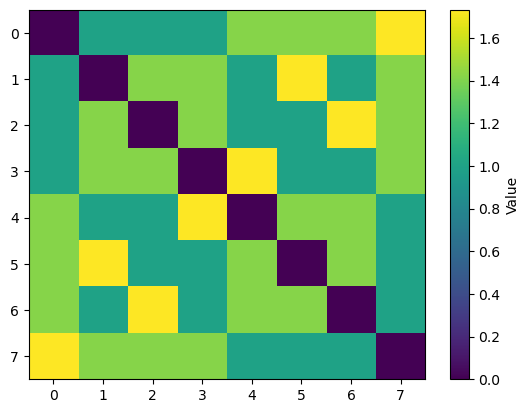

In [16]:
# Plot heatmap
plt.imshow(distances, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')

## Indexing

### Regular indexing
You can of course use the "regular" python indexing with slices for numpy arrays. But there are other ways as well, as you can see below. As an example, we will use the case where you want to create a 'larger' hamiltonian from blocks of smaller matrices. (note that our particular example could be done via a numpy function `blocks` for the purpose instead, but for now we do it with indexing.)

In [17]:
# Example arrays first
def get_example_matrices():
    A, B = np.arange(int(2**3)).reshape(2, 2, 2)
    V = np.array([[0, 1], [1, 0]])
    H0 = np.zeros((4, 4))
    return A, B, V, H0

A, B, V, H0 = get_example_matrices()
print("A=",A)
print("B=",B)
print("V=",V)
print("H0=",H0)

A= [[0 1]
 [2 3]]
B= [[4 5]
 [6 7]]
V= [[0 1]
 [1 0]]
H0= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [18]:
# First, put A and B into H0 with slices:
A, B, V, H0 = get_example_matrices()
H0[0:2, 0:2] = A
H0[2:4, 2:4] = B
H0[0:2, 2:4] = V
H0[2:4, 0:2] = V.T
print(H0)

[[0. 1. 0. 1.]
 [2. 3. 1. 0.]
 [0. 1. 4. 5.]
 [1. 0. 6. 7.]]


In [21]:
# You can also use some fancier indexing. Say you have defined two regions of indices:
reg0 = np.array([0, 1])  # say region 0 is atoms 0 and 1
reg1 = np.array([2, 3])  # and region 1 is atoms 2 and 3
# Now the trick is, we want to use broadcasting. So these regions need an extra dimension:
reg0 = reg0[:, None]  # Using None is the same as using `newaxis`
reg1 = reg1[:, None]
# Then we can put together the hamiltonian like before:
A, B, V, H0 = get_example_matrices()
H0[reg0, reg0.T] = A
H0[reg1, reg1.T] = B
H0[reg0, reg1.T] = V
H0[reg1, reg0.T] = V.T
print(H0)

[[0. 1. 0. 1.]
 [2. 3. 1. 0.]
 [0. 1. 4. 5.]
 [1. 0. 6. 7.]]


In the second of the two examples above, you could have used the same slice objects as in the first example instead of arrays to define your regions. The advantage to using arrays is that the ***indices don't have to be regularly spaced***.

The assigment of values to H0 could also have been done using a nested for-loop. This way is shown below, is the slowest and most manual way of doing it, but it may be easier to include some more involved conditions for when to put what values into H0:

In [22]:
A, B, V, H0_2 = get_example_matrices()
for i in range(2):
    for j in range(2):
        H0_2[i,j]      = A[i,j]
        H0_2[i+2, j+2] = B[i,j]
        H0_2[i  , j+2] = V[i,j]
        H0_2[i+2, j  ] = V.T[i,j]
print(H0_2)

[[0. 1. 0. 1.]
 [2. 3. 1. 0.]
 [0. 1. 4. 5.]
 [1. 0. 6. 7.]]


### Comparing arrays
There are different options for comparing arrays in python and in numpy. We will use the "assert" command, if what comes after it evaluates to False.   

#### Identity
Here we check if the array elements are exactly equal. Note that if this is actually a very strict requirement and two matrices that are equal on paper will not be strictly equal if you calculate them in different ways or with different functions in python. This is because of floating point precision of the computer

In [23]:
assert (H0 == H0_2).all()    # assert that all elements are equal

print(H0 == H0_2)            # Inspect which elements are equal

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


#### "Close"
What we most often care about is if numpy arrays are almost equal, which we can check using the "allclose" from numpy. 

In [27]:
assert np.allclose(H0, 0.99999*H0_2)
print(np.isclose(H0, 0.999*H0_2))

[[ True False  True False]
 [False False False  True]
 [ True False False False]
 [False  True False False]]


#### Other tests
You can of course also see if something is greater than or lesser than

In [31]:
print(H0>2)
print(H0<3)
val = 2
print('There are', np.sum(H0<3), 'values less than', val)

[[False False False False]
 [False  True False False]
 [False False  True  True]
 [False False  True  True]]
[[ True  True  True  True]
 [ True False  True  True]
 [ True  True False False]
 [ True  True False False]]
There are 11 values less than 2


## Linear algebra operations
Here we will take a look at some of the most common linear algebra operations. We will cover matrix inversion, matrix multiplication, elementwise multiplication, and utilising broadcasting for speed. ***Note: It is always the last two indices that behave as matrix indices.***

In [37]:
# Shorthands
Inv = np.linalg.inv
Tr  = np.trace
MM  = np.matmul      # Short
# Test arrays
# The first two indices (with lengths n1 and n2) are vectorised over in what we will be doing
# The last two indices will be behaving as the matrices regular linear algebra
n1 = 12
n2 = 15
A = np.random.random((n1,n2,10,10))
B = np.random.random((n1,n2,20,10))
C = np.random.random((n1,n2,10,20))
D = np.random.random((n1,n2,20,20))


#### Generic operations

In [38]:
A + A      # 2A
A - A      # 0A
A * A      # Elementwise multiplication
A / A      # Elementwise division
1j * A     # i*A
np.conj(A) # complex conjugation
np.imag(A) # imaginary part of A (zero)
np.real(A) # real part of A


array([[[[7.90831219e-01, 2.82886050e-01, 3.72297507e-01, ...,
          5.11288426e-01, 5.78324507e-01, 3.09179896e-01],
         [9.79222245e-01, 5.54464059e-02, 2.55215328e-01, ...,
          9.90138106e-01, 6.17457486e-01, 5.75128350e-01],
         [6.49719127e-01, 7.74067163e-01, 2.64261916e-01, ...,
          1.65523200e-01, 8.32271325e-01, 8.35741576e-01],
         ...,
         [4.66109016e-01, 2.62538893e-01, 9.32405946e-01, ...,
          7.06283041e-01, 1.90921433e-01, 3.40446202e-02],
         [6.24964670e-01, 1.61018616e-01, 6.94594401e-01, ...,
          5.79502572e-01, 4.29353880e-01, 5.97596425e-01],
         [7.04640217e-02, 3.68974095e-01, 8.81105207e-01, ...,
          1.68551467e-01, 9.13468214e-01, 7.63284936e-01]],

        [[6.34368723e-01, 1.60974693e-01, 6.50255706e-01, ...,
          1.40141846e-01, 2.84045886e-03, 7.11846947e-01],
         [5.21881073e-01, 5.24590836e-01, 7.44535538e-01, ...,
          8.06465527e-01, 9.32047623e-01, 6.72219579e-01],
        

### Matrix multiplication
If you look at the shape of the matrices A, B, C and D, there are only some combinations we can make that doesnt give an error. We should note you can use the shorthand MM or you can use the "@" operator which is even shorter

In [39]:
# selection of valid operations
MM(A,A)
MM(D,D)
MM(B,C)
MM(B,B.transpose(0,1,3,2))
# selection of operations that yield an error, consider why this is
# MM(B,B)
# MM(C,C)
# MM(A,D)
# This is faster than doing the equivalent for-loop.
def f(A,B):
    res = np.zeros((n1,n2)+(A.shape[-2],B.shape[-1]))
    for i in range(n1):
        for j in range(n2):
            res[i,j,:,:] = np.dot(A[i,j], B[i,j])
    return res
%timeit res3 =  f(D,D)
%timeit res4 =  MM(D,D) # same as D@D


448 μs ± 6.86 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
98.4 μs ± 6.14 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


###  Matrix Inversion
again, ***only the last two incides are treated as matrix indices, the rest is vectorised over***. It is again faster to use the broadcasting if it is possible instead of doing the for-loop as in the matrix-multiplication example. The only exception is if the case you want to do requires more RAM than your computer has, then doing the manual for-loop is necessary. 

In [40]:
inv_A = Inv(A)
i,j = 2,1 # the particular two first indices we take out
print(r'The trace of A^{'+str(i)+','+str(j)+'}*(A^{'+str(i)+','+str(j)+'})^{-1} is',Tr( MM(A[i,j], inv_A[i,j]) ), 
       '\nDoes this make sense? (hint: look at the shape of the matrix)')


The trace of A^{2,1}*(A^{2,1})^{-1} is 10.0 
Does this make sense? (hint: look at the shape of the matrix)


In [49]:
inv_A.shape

(12, 15, 10, 10)

### Trace  / Trace of Product
The trace command is very similar, with the exception that we have to specify which axes the trace should be taken over if the array has more than two indices. There is a fast way to calculate the trace of products because only the diagonal needs to be calculated

In [50]:
# Trace of matrix
res1 = Tr(A, axis1 = 2, axis2 = 3)
print(res1.shape) # it is a 50x100 array here because the diagonal of the matrix indices are summed over 
i,j = 2,5
assert np.isclose(res1[i,j], Tr(A[i,j]))

#Trace of Product
#slow way
res2 = Tr(MM(B,C),axis1 = 2, axis2 = 3)
#faster, less obvious way. Write out the diagonal of B@C on paper if you want to see why this is.
res3 = np.sum(B*(C.transpose(0,1,3,2)), axis = (2,3))

i,j = 5,11
assert np.isclose(res2[i,j], res3[i,j])

#Timings
%timeit Tr(MM(B,C),axis1 = 2, axis2 = 3)
%timeit np.sum(B*(C.transpose(0,1,3,2)), axis = (2,3))

(12, 15)
73.6 μs ± 2.88 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
46.5 μs ± 453 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
